In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import pickle

### System Dynamics Component

In [ ]:
def lambda_function(presenting_rate, gatekeeping_threshold, stocks, population):
    """
    Vectorized function to calculate the lambda values for each stock.

    Args:
        presenting_rate: a positive float <= 1
        gatekeeping_threshold: a positive float <= 1
        stocks: a list of stocks (number of patients in each stock)
        population: a positive integer representing the total population
    """
    stocks = np.array(stocks)
    lambdas = []

    for i in range(len(stocks)):
        if i == 0:
            subtracted = 0
        else:
            subtracted = sum(stocks[:i])
        if stocks[i] > 0:
            ratio = ((gatekeeping_threshold * population) - subtracted) / stocks[i]
        else:
            ratio = 0
        lambdas.append(presenting_rate * np.clip(ratio, 0, 1) * stocks[i])
    return lambdas

In [ ]:
class SD:
    """
    A class to hold the SD component.
    """

    # changed the parameters to match the SD model
    def __init__(
        self,
        initial_population,
        unwell_proportion,
        unwell_splits,
        gatekeeping_threshold,
        presenting_rate,
        deterioration_rate,
        incidence_rate,
        **kwargs,
    ):
        """
        Initialised the parameters for the SD component

        Args:
            initial_population: a positive integer
            unwell_proportion: a positive float <= 1
            unwell_splits: a tuple of three floats that sum to 1
            gatekeeping_threshold: a positive float <= 1
            presenting_rate: a positive float <= 1
            deterioration_rate: a positive float <= 1
            incidence_rate: a positive float <= 1
            birth_rate: a positive float
        """
        w = unwell_splits
        self.initial_population = initial_population
        unwell_pop = initial_population * unwell_proportion
        self.P = [unwell_pop * w[0], unwell_pop * w[1], unwell_pop * w[2]]
        self.presenting_rate = presenting_rate
        self.gatekeeping_threshold = gatekeeping_threshold
        self.deterioration_rate = deterioration_rate
        self.incidence_rate = incidence_rate
        self.time = np.array([0])

    def differential_equations(
        self,
        y,
        time_domain,
    ):
        """Defines the system of differential equations that describe the
        population model.

        Args:
            y: a tuple of three integers
            t: a positive float

        Returns:
            A tuple containing dP_onedt, dP_twodt, P_threedt
        """
        P_one, P_two, P_three = y
        N_current = P_one + P_two + P_three
        all_stocks = [P_one, P_two, P_three]

        if N_current == 0:
            return 0, 0, 0

        susceptible_population = max(self.initial_population - N_current, 0)
        lambdas = lambda_function(
            self.presenting_rate,
            self.gatekeeping_threshold,
            stocks=all_stocks,
            population=N_current,
        )

        dP_onedt = -lambdas[0] + self.deterioration_rate * P_two
        dP_twodt = (
            -lambdas[1]
            - (self.deterioration_rate * P_two)
            + (self.deterioration_rate * P_three)
        )
        dP_threedt = (
            -lambdas[2]
            - (self.deterioration_rate * P_three)
            + (self.incidence_rate * susceptible_population)
        )
        return dP_onedt, dP_twodt, dP_threedt

    def solve(
        self,
        t,
    ):
        """
        Solves the differential equations from the time of the previous event
        to time t.
        """
        # Solve the SD over the relevant time domain
        y = self.P
        results = odeint(
            self.differential_equations,
            y,
            t,
        )

        P1, P2, P3 = results.T
        self.P[0] = np.append(self.P[0], P1)
        self.P[1] = np.append(self.P[1], P2)
        self.P[2] = np.append(self.P[2], P3)

        # Extract the lambdas from the results
        self.lambdas = lambda_function(
            self.presenting_rate,
            self.gatekeeping_threshold,
            stocks=[P1, P2, P3],
            population=P1 + P2 + P3,
        )

In [4]:
A = SD(
    initial_population=100000,
    unwell_proportion=0.1,
    unwell_splits=[0.1, 0.3, 0.6],
    gatekeeping_threshold=0.4,
    presenting_rate=0.002 / 3,
    deterioration_rate=0.005,
    incidence_rate=0,
)
ts = np.linspace(0, 1000, 100000 + 1)
A.solve(t=ts)

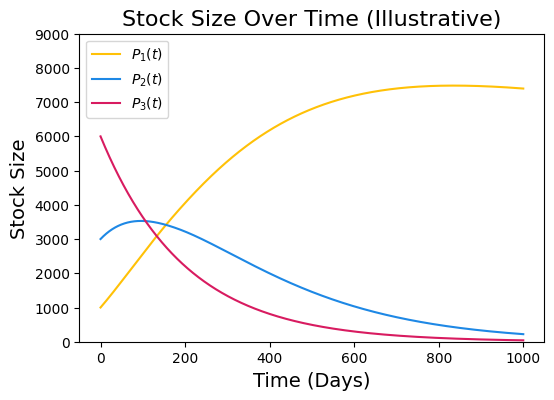

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 4)
ax.plot(ts, A.P[0][1:], label="$P_1(t)$", color="#FFC107")
ax.plot(ts, A.P[1][1:], label="$P_2(t)$", color="#1E88E5")
ax.plot(ts, A.P[2][1:], label="$P_3(t)$", color="#D81B60")
ax.set_title("Stock Size Over Time (Illustrative)", fontsize=16)
ax.set_xlabel("Time (Days)", fontsize=14)
ax.set_ylabel("Stock Size", fontsize=14)
ax.set_ylim(0, 9000)
ax.legend(fontsize=10)
plt.savefig("stock_size.png", dpi=300, bbox_inches="tight", transparent=True)

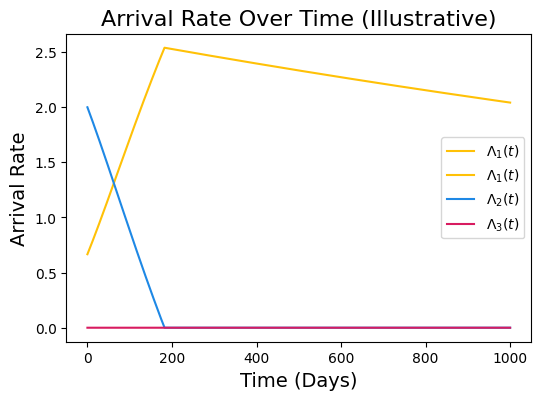

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 4)
ax.plot(ts, A.lambdas[0], 0, label="$Λ_1(t)$", color="#FFC107")
ax.plot(ts, A.lambdas[1], label="$Λ_2(t)$", color="#1E88E5")
ax.plot(ts, A.lambdas[2], label="$Λ_3(t)$", color="#D81B60")
ax.set_title("Arrival Rate Over Time (Illustrative)", fontsize=16)
ax.set_xlabel("Time (Days)", fontsize=14)
ax.set_ylabel("Arrival Rate", fontsize=14)
ax.legend(fontsize=10)
plt.savefig("arrival_rate.png", dpi=300, bbox_inches="tight", transparent=True)

### Loading the Subgroup PDFAs

In [8]:
pdfa_one = np.load("pdfas/example_high_pdfa.npy")
pdfa_one_alphabet = pickle.load(open("pdfas/example_high_pdfa_alphabet.pkl", "rb"))

In [9]:
pdfa_two = np.load("pdfas/example_medium_pdfa.npy")
pdfa_two_alphabet = pickle.load(open("pdfas/example_medium_pdfa_alphabet.pkl", "rb"))

In [10]:
pdfa_three = np.load("pdfas/example_low_pdfa.npy")
pdfa_three_alphabet = pickle.load(open("pdfas/example_low_pdfa_alphabet.pkl", "rb"))

In [11]:
activity_dict = dict()
activity_dict["A"] = 2
activity_dict["B"] = 3
activity_dict["C"] = 4
activity_dict["D"] = 5
activity_dict["F"] = 6
activity_dict["G"] = 7
activity_dict["H"] = 8
activity_dict["I"] = 9
activity_dict["J"] = 10
inv_dict = {v: k for k, v in activity_dict.items()}
inv_dict[1] = ""

In [12]:
nodes = ["*", "A", "B", "C", "D", "F", "G", "H", "I", "J"]

### Discrete-Event Simulation Component

In [15]:
class HighCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_one
        alphabet = pdfa_one_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [14]:
class MediumCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_two
        alphabet = pdfa_two_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [13]:
class LowCustomRouting(ciw.routing.NodeRouting):
    def next_node(self, ind):
        p_matrix = pdfa_three
        alphabet = pdfa_three_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [16]:
N = ciw.create_network(
    arrival_distributions={
        "Low": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[2][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "Medium": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[1][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "High": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[0][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    },
    service_distributions={
        "Low": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "Medium": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "High": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
    },
    number_of_servers=[float("inf"), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    routing={
        "Low": ciw.routing.NetworkRouting(
            routers=[
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
            ]
        ),
        "Medium": ciw.routing.NetworkRouting(
            routers=[
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
            ]
        ),
        "High": ciw.routing.NetworkRouting(
            routers=[
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
            ]
        ),
    },
)

In [17]:
Q = ciw.Simulation(N)
Q.simulate_until_max_time(1000)
r = pd.DataFrame(Q.get_all_records())
r

,id_number,customer_class,original_customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,server_id,record_type
0,2325,High,High,1,998.859868,0.000000,998.859868,0.000000,998.859868,0.0,998.859868,2,0,0,False,service
1,2325,High,High,2,998.859868,0.000000,998.859868,0.100000,998.959868,0.0,998.959868,5,0,0,1,service
2,2325,High,High,5,998.959868,0.000000,998.959868,0.285714,999.245582,0.0,999.245582,6,0,0,1,service
3,2318,High,High,1,996.395402,0.000000,996.395402,0.000000,996.395402,0.0,996.395402,3,0,0,False,service
4,2318,High,High,3,996.395402,0.000000,996.395402,0.100000,996.495402,0.0,996.495402,5,0,0,1,service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12347,2323,High,High,9,997.727897,0.000000,997.727897,0.285714,998.013611,0.0,998.013611,2,0,0,1,service
12348,2323,High,High,2,998.013611,0.000000,998.013611,0.100000,998.113611,0.0,998.113611,5,0,1,1,service
12349,2323,High,High,5,998.113611,0.000000,998.113611,0.285714,998.399326,0.0,998.399326,10,0,1,1,service
12350,2323,High,High,10,998.399326,0.023028,998.422354,0.312500,998.734854,0.0,998.734854,10,1,1,1,service
